# Capstone Project
## Machine Learning Engineer Nanodegree
Ralph Fehrer 
October 15th, 2015

## I. Definition
### Project Overview
This projects implements a trading agent using *Q-learning* as a specific *reinforcement learning* technique to learn to make autonomous trading decisions, based on market states and expected wins/losses. The main question this project tries to answer is a very basic one: 

    Is a Q-learning trading agent able to learn something useful in a specific day-trading setting?

Due to the highly complex nature of market data, the lack of reproducible benchmarks and since reinforcement learning is still a very active research area, it is by no means guaranteed that the first approaches to a Q-learning trading agent result in a succesful active trading system. For this reason, another major goal of this project is to provide a base implementation, that allows to experiment with different parameter settings and reinforcement learning approaches. 

### Problem Statement

The Q-learning trading agent is provided with market state data several times per trading day by the market environment. Based on this market state and previous experience which is represented by a Q-table, the trading agent autonomously makes a trading decision. The wins or losses resulting from this trading decisions are then used by the trading agent to update its Q-table. 

The basic interactions between agent and market environment are illustrated by the following figure.

![alt text](https://github.com/fera0013/machine-learning/blob/master/projects/capstone/self_learning_trading_agent/images/AgentEnvironmentInteractions.png?raw=true "Fig 1: Agent-environment interactions")

Based on the general description above, the following major- and sub-elements can be identified:

1. (Market) environment
  * Market data component that provides historical price data for the traded asset in minute-resolution
  * Technical analysis component to calculate the market state based on the historical price data
  * Order component which allows the agent to enter and close positions
  * Position component to calculate the current value (or reward) of a position
2. Trading agent
  * *Q-table* mapping each possible state/action pair to value that represents the expected win or loss if the agent takes action *a* in state *s*
  * Algorithm to update the *Q-table* based on the current state, the chosen trading action and the win or loss
  * Total-reward metric, which contains the accumulated wins or losses at any update step
 
In order to simplify the highly complex task of developing a Q-learning trading agent, the following restrictions are specified:

- The trading agent acts in a day trading setting, i.e. any open position is automatically closed at the end of a trading session
- The state is discrete and is derived from the following set of popular indicators: 
  * Moving Average Convergence Divergence (MACD)
  * Bollinger Bands
  * Relative Strength Index (RSI)
- The update interval is 1 minute, i.e. the agent gets the most recent state, makes a trading decision and updates its *Q-table* once per minute during a day trading session
- Only one asset is traded, namely the *S&P 500 ETF*, refered to by its symbol name *SPY*
- The set of available actions is restricted to the following four: 
  * Take a long position equalling 100% of the portfolio value
  * Take a short position equalling 100% of the portfolio value
  * Do nothing 
  * Close an open position 
- The set of allowed actions at any update step depends on the current position sub-state, the trading state transitions are illustrated by the following figure. 
  
![alt text](https://github.com/fera0013/machine-learning/blob/master/projects/capstone/self_learning_trading_agent/images/TradingStateTransitions.png?raw=true "Fig 2: Trading state transitions")

### Metrics

The most important metric to measure the performance of the self-learning trading agent is the total reward, i.e. the position values accumulated over all updated steps over all trading days. The total reward achieved by the reinforced trading agent is then compared to the performance of a "monkey trader", i.e. an agent that just randomly picks an action at any update step without learning anything. This type of benchmarking helps to answer the question, if the intelligent agent learns anything at all in the given setting. 

## II. Analysis

### Data Exploration
The market data is provided by *Quantopian*. According to their contract with the original data vendors, this marked data can only be obtained and used within the Quantopian research environment. The API-function *get_pricing* returns open-high-low-close (*OHLC*) data for a large number of assets, with a maximum resolution of 1 minute over several years. The data is split- but not divident adjusted. This does however not pose any problem, since the agent is not compared to a market benchmark. In this project, *SPY* close data with a resolution of 1 minute is used, for a period of 1 year(+). 

### Exploratory Visualization

The market data is obtained through the *get_pricing* in the *Quantopian* research environment. This function returns a *pandas.Panel*-object with columns depending on the requested data and a datetime-index. For more details, see https://www.quantopian.com/help.

The following code snippet imports the historical data of the *S&P 500*-etf (*SPY*) which is used in all subsequent parts of this project:

In [133]:
import zipline
start_date='2015-02-18'
end_date='2016-02-18'
data = get_pricing(
    ['SPY'],
    start_date=start_date,
    end_date = end_date,
    frequency='minute'
)
print data.price.head()
print data.price.tail()

                           Equity(8554 [SPY])
2015-02-18 14:31:00+00:00              209.59
2015-02-18 14:32:00+00:00              209.60
2015-02-18 14:33:00+00:00              209.61
2015-02-18 14:34:00+00:00              209.55
2015-02-18 14:35:00+00:00              209.59
                           Equity(8554 [SPY])
2016-02-18 20:56:00+00:00            191.9199
2016-02-18 20:57:00+00:00            191.9850
2016-02-18 20:58:00+00:00            192.0200
2016-02-18 20:59:00+00:00            191.9650
2016-02-18 21:00:00+00:00            192.0400


The price data is used to calculate the market state, which is based on the values of three popular technical indicators. The following code snippet calculates the *MACD*, *RSI* and *Bollinger Bands* with a minute resolution for one specific day, using the *talib* implementation (see https://mrjbq7.github.io/ta-lib/). The values of the technical indicators and the *SPY* price are then combined in a single *pandas.DataFrame*, to pass them to a plotting function.

In [134]:
import pandas as pd
import talib
from datetime import datetime
asset_data = data.price.loc[start_date].rename(columns={data.price.columns[0]: 'SPY'})
prices=asset_data.SPY.as_matrix()
macd_raw, macd_signal, macd_hist =  talib.MACD(prices, fastperiod=12,slowperiod=26,signalperiod=9)
asset_data['macd_raw']=macd_raw
asset_data['macd_signal']=macd_signal
asset_data['macd_hist']=macd_hist
bb_upper, bb_middle, bb_lower = talib.BBANDS(prices,timeperiod=12,nbdevup=2,nbdevdn=2,matype=0)
asset_data['bb_upper']=bb_upper
asset_data['bb_middle']=bb_middle
asset_data['bb_lower']=bb_lower
rsi =talib.RSI(prices, timeperiod=7)
asset_data['rsi']=rsi
#spy_price_data.fillna(0,inplace=True)
print asset_data.head()
print asset_data.tail()

                              SPY  macd_raw  macd_signal  macd_hist  bb_upper  \
2015-02-18 14:31:00+00:00  209.59       NaN          NaN        NaN       NaN   
2015-02-18 14:32:00+00:00  209.60       NaN          NaN        NaN       NaN   
2015-02-18 14:33:00+00:00  209.61       NaN          NaN        NaN       NaN   
2015-02-18 14:34:00+00:00  209.55       NaN          NaN        NaN       NaN   
2015-02-18 14:35:00+00:00  209.59       NaN          NaN        NaN       NaN   

                           bb_middle  bb_lower  rsi  
2015-02-18 14:31:00+00:00        NaN       NaN  NaN  
2015-02-18 14:32:00+00:00        NaN       NaN  NaN  
2015-02-18 14:33:00+00:00        NaN       NaN  NaN  
2015-02-18 14:34:00+00:00        NaN       NaN  NaN  
2015-02-18 14:35:00+00:00        NaN       NaN  NaN  
                               SPY  macd_raw  macd_signal  macd_hist  \
2015-02-18 20:56:00+00:00  210.000 -0.025799    -0.032094   0.006295   
2015-02-18 20:57:00+00:00  210.020 -0.018391 

Please note that the first several indicator values are automatically set to *NaN*. This is an expected result, since the indicators are based on *moving averages* that need a certain period of historical data for its calculation. It is also a desired result, since the plotting functions just ignore *NaN*, which is the correct treatment of for non-existing values.

To visualize the complete data, the following function is defined:

In [135]:
import matplotlib.pyplot as plt
def plot_data(day,data,transactions=None):
    #spy_price_data.fillna(0,inplace=True)
    textsize = 9
    left, width = 0.1, 0.8
    rect1 = [left, 0.7, width, 0.2]
    rect2 = [left, 0.3, width, 0.4]
    rect3 = [left, 0.1, width, 0.2]
    fig = plt.figure(facecolor='white')
    ax1 = fig.add_axes(rect1)
    ax2 = fig.add_axes(rect2,sharex=ax1)
    ax3 = fig.add_axes(rect3,sharex=ax1)
    ax1.set_title(day)
    # plot the relative strength indicator
    ax1.plot(data.index,data['rsi'])
    ax1.set_xlim(data.index[0],data.index[-1])
    ax1.legend()
    #plot price and bollinger band in the 2nd axes            
    ax2.plot(data.index, data['SPY'])
    color=''
    ax2.plot(data.index,data['bb_upper'],color='grey',lw=0.5)
    ax2.plot(data.index,data['bb_middle'],color='grey',lw=0.5)
    ax2.plot(data.index,data['bb_lower'],color='grey',lw=0.5)
    if transactions is not None:
        for i in range(0, len(transactions),2):
            if (i+1)<len(transactions):
                entry=transactions[i]
                exit=transactions[i+1]
                entry_price=entry['price']
                exit_price=exit['price']
                entry_amount=entry['amount']
                if (exit_price-entry_price)*entry_amount>0:
                    color='green'
                else:
                    color = 'red'
                ax2.plot([entry['dt'].time(),exit['dt'].time()],[entry['price'],exit['price']],color=color,linestyle='--')
    ax2.yaxis.tick_right()
    ax2.legend()
    # plot the MACD indicator
    ax3.plot(data.index,data['macd_raw'])
    ax3.plot(data.index,data['macd_signal'])
    ax3.fill_between(data.index,data['macd_hist'], 0, alpha=0.5)
    ax3.legend()
    for ax in ax1, ax2,ax3:
        if ax != ax3:
            for label in ax.get_xticklabels():
                label.set_visible(False)
        else:
            for label in ax.get_xticklabels():
                label.set_rotation(30)
                label.set_horizontalalignment('right')
    plt.show()

To illustrate the market data, the *DataFrame* constructed above is passed to the *plot_data* function:

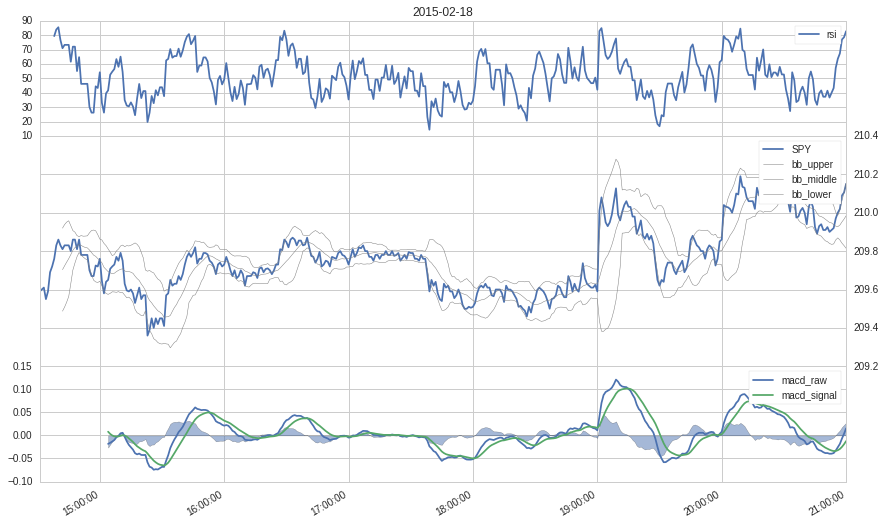

In [136]:
plot_data(start_date,asset_data)

### Algorithms and Techniques

The self-learning trading agent uses the *Q-learning* algorithm to learn making trading decisions, which - in its general form - can be stated as follows:

                     Initialize Q(s, a), ∀s ∈ S, a ∈ A(s), arbitrarily, and Q(terminal-state, ·) = 0 
                     Repeat (for each episode): 
                       Initialize S
                       Repeat (for each step of episode): 
                          Choose A from S using policy derived from Q (e.g., ε-greedy) 
                          Take action A, observe R, S' 
                          Q(S, A) ← Q(S, A) + α[R + γ*max<a>Q(S', a) − Q(S, A)]  
                          S ← S'  
                       until S is terminal 

Where 

- *S* is the set of possible states a learner can experience in a given environment
- *A(s)* is the set of actions a learner can choose from in a specific state **s**
- *Q(s, a)* maps each state/action pair to a numeric value representing the reward an agent can expect, if he selects action *a* in state *s*
- An *episode* is one repetition of the same learning task, starting in a start state and ending in a terminal state
- *ε-greedy* is a method to control the exploration/exploitation tradeoff 
- *R* is the reward the agent receives for taking action *a* in state *s*
- *α* is the learning rate which can be set to any value between 0 and 1 and controls the step size in the direction of the gradient on any update step. a lower value for *α* requires more update steps to find an optimum, but avoids getting stuck in local maxima or minima. 
- *γ* is the discount rate, which controls the tradeoff between immediate reward and longer term gratification. The value of γ can be set to any value between 0 and 1, where a value of 0 results in a learner focusing only on the immediate reward for the current step, while a larger value means the learner also considers later rewards for taking a specific action *a* in a specific state *s*.

Several aspects of the self-learning trader system can easily be assigned to individual elements of the algorithm:

- An episode equals one trading day, the end of an episode is not marked by a terminal state, but by the end of a trading session 
- The set of states *S* are derived from values and specifics of the technical indicators introduced above 
- The set of possible actions *A(s)* in state s is defined by position sub-state
- The reward for an existing position is calculated by *(current_price-entry_price)sign(position_size)* at every update step, where position_size can either be 100,-100 depending on whether a long, a short or no position was taken. If there is no current position, the reward is 0.
- The step size is 1 minute, i.e. the update part of the algorithm is executed every minute for each episode

The general algorithm was slightly adapted due to some specifics of the problem domain and restriction of the environment. The version implemented for this project can be stated as follows: 

    
                     Repeat (for each trading day):
                       prevS<-None  
                       prevA<-None
                       Repeat (for each trading_day in trading_days):
                          R <- current reward (i.e, value of current position)
                          S <- current state
                          If S not in Q-table, Initialize Q(S, a), ∀s a ∈ A(s)
                          Choose A from S using policy derived from Q (ε-greedy) 
                          Take action A 
                          if prevS is not None and prevA is not None
                              Q(prevS,prevA) ← Q(prevS,prevA) + α[R + γ*max<a>Q(S, a) − Q(prevS, prevA)]  
                          prevS<-S  
                          prevA<-A 
                       Until 30 minutes before trading session end
                      
α will be set to a low value, to prevent getting stuck in local minima. To encourage the agent to favour longer term trades dending on indicator trend signals,  γ is set to 0.8. At the same time, the high value of γ is supposed to prevent short term trades that are highly susceptible to noise. epsilon is set to 0.1, such that - in frequentist terms -  the agent uniformly draws from the set of allowed actions at every ninth update step, instead of taking the action *a* which maximizes *Q(S,a)*. This ensures that the agent keeps exploring even in later episodes, which intuitively seems desirable given the complex and dynamic characteristics of the market environment. 

### Benchmark
Main purpose of this project is to answer the question, if a Q-learning trading agent is able to learn anything useful at all, given a (simplified) day-trading setting. The performance of the the learning agent is therefore not compared to a common market benchmark, but much rather to another agent - a "monkey trader" - which definitely does not learn anything at all. This monkey trader acts in exactly the same environment and follows the same state transition rules as the self-learning agent. The only difference is, that the monkey trader at any update step just uniformly draws from the set of allowed actions and thus does not follow any learned policy whatsoever.
If the self-learning agent is not able to perform significantly better than the monkey trader, it is not worth pursuing further. If it does perform considerably better, the next step would be to compare its performance to a common market benchmark, to see if it could be a viable candidate for an automated, active trading system.

## III. Methodology

### Data Preprocessing

The data exhibits no abnormalities, and can be used without preprocessing as returned by the *get_pricing* function.

### Agent implementation

In [137]:
class SelfLearningTradingAgent():
    def __init__(self,environment):
        self.environment=environment
        self.available_actions=['none','long','short','close']
        self.allowed_actions={
            'long':['none','close'],
            'short':['none','close'],
            'none':['none','long','short']}
        self.total_reward=[0]
        self.number_of_episodes=0
    def init_new_episode(self):
        pass
    def learn(self,state,reward,action):
        pass
    def update(self,state):
        reward = self.get_reward()
        self.total_reward.append(self.total_reward[-1]+reward)
        next_action = self.choose_next_action(state)
        self.act(next_action)
        self.learn(state,reward,next_action)
    def choose_next_action(self,state):
        pass
    def act(self,action):
        if  self.environment.trading_stopped is True:
            #Close any open trade towards the end of a trading day 
            if  self.environment.portfolio.positions[self.environment.SPY].amount!=0:
                order_target(self.environment.SPY, 0)
            return
        if action == 'close':
            order_target(self.environment.SPY, 0)
            self.environment.position= 'none'
        if action == 'long':
            order_target(self.environment.SPY, 100)
            self.environment.position= 'long'
        if action == 'short':
            order_target(self.environment.SPY, -100)
            self.environment.position= 'short'
    def get_reward(self):
        reward = 0
        if self.environment.portfolio.positions[self.environment.SPY].amount!=0:
            current_price=self.environment.portfolio.positions[self.environment.SPY].last_sale_price
            original_price=self.environment.portfolio.positions[self.environment.SPY].cost_basis
            amount=self.environment.portfolio.positions[self.environment.SPY].amount
            reward = (current_price-original_price)*np.sign(amount)
        return reward

Using the base abstraction, the *MonkeyTrader*-benchmark only has to override the *choose_next_action* method, such that an action is uniformly drawn from the set of allowed actions at every update step:

In [139]:
from numpy import random
random.seed(40)
class MonkeyTrader(SelfLearningTradingAgent):
    def choose_next_action(self,state):
        return random.choice(self.allowed_actions[self.environment.position])

The *QLearningTrader* uses the base abstraction and implements/overides all methods required for Q-learning:

In [140]:
import numpy as np
import scipy
class QLearningTrader(SelfLearningTradingAgent):
    def __init__(self,environment,alpha,gamma):
        SelfLearningTradingAgent.__init__(self,environment)
        self.alpha=alpha
        self.gamma=gamma
        #The Q-table is represented by a pandas.DataFrame. 
        #This may be not the most memory-efficient solution, 
        #since the DataFrame will contain cells for actions that are not allowed in certains states
        #and are therefore never needed nor used and set to NaN.
        #A pandas.DataFrame does however provide rich and convenient functionalities that can be used to analyse the Q-table 
        #which more than justifies some waste of memory in a research setting.
        self.q_table=pd.DataFrame(columns=self.available_actions)
        self.previous_state=None
        self.previous_action=None
    def init_new_episode(self):
        self.previous_state=None
        self.previous_action=None
    def get_epsilon(self):
        return 0.1
    def extend_q_table_for(self,state):
        #Set q values for new state to NaN for all actions
        self.q_table.loc[str(state)] = [np.NaN]*len(self.available_actions)
        #initialize q values of allowed actions for new state with 0
        allowed_actions = self.allowed_actions[state['position']]
        [self.q_table.set_value(str(state),action,0) for action in allowed_actions]
    def get_actions_with_maximal_q_values_for(self,state):
        return self.q_table.ix[:,self.q_table.ix[str(state)] == self.q_table.ix[str(state)].dropna().max()].columns.tolist()
    def get_q_value(self,state,action):
        if str(state) not in self.q_table.index:
            self.extend_q_table_for(state)
        return self.q_table.loc[str(state),action]
    def set_q_value(self,state,action,q_value):
        self.q_table.loc[str(state),action]=q_value
    def choose_next_action(self,state):
        actions=[]
        if scipy.stats.bernoulli.rvs(1-self.get_epsilon()):
            if str(state) not in self.q_table.index:
                self.extend_q_table_for(state)
            actions = self.get_actions_with_maximal_q_values_for(state)
        else:
            actions= list(self.allowed_actions[state['position']])   
        return random.choice(actions)
    def learn(self,state,reward,action):
        if self.previous_action is not None:
            #The bellman equation
            new_q_value=(1-self.alpha)*self.get_q_value(self.previous_state,self.previous_action)+self.alpha*(reward+self.gamma*max([self.get_q_value(state,act) for act in self.allowed_actions[state['position']]])) 
            self.set_q_value(self.previous_state, self.previous_action,new_q_value)
        self.previous_action = action
        self.previous_state = state        

### Environment implementation
The *Quantopian* research environment is still in a beta phase, i.e. it may contain some bugs and will very likely change before release. These restrictions of the *Quantopian* research environment are however more than outweighed by the following advantages:

- Professional, split-adjusted market data, for a large number of assets, over long time periods and with minute resolution
- Order infrastructure, that allows to place orders under (simulated) market conditions including slippage and commision models
- Portfolio infrastructure which allows the analysis of current positions
- Comprehensive performance measure facilities, including the calculation of most common portfolio metrics
- Almost seamless portability of algorithms developed in the research environment to a live trading environment (*Quantopian IDE*), which supports paper- and live trading against a real broker account
- Easy collaboration opportunities, enabled by the notebook hosting

The first method is executed thirty minutes before session and activates a signal that triggers the agent to close any open position at the next update step:

In [141]:
def do_thirty_minutes_before_session_ends(context, data):
    context.trading_stopped=True

The following *initialize* functions are called once at the beginning of the execution of each trading algorithm instance. Every algorithm-global variable has to be initialized and appended to the *context*-object in this function. Two versions of this function are needed, one for the *MonkeyTrader* benchmark and one for the *QLearningTrader*. 

In [142]:
def initialize_monkey_trader(context):
    context.data_to_record=['SPY',
                            'macd_raw',
                            'macd_signal',
                            'macd_hist',
                            'bb_upper',
                            'bb_middle',
                            'bb_lower',
                            'rsi',
                            'state']
    context.position='none'
    context.trading_stopped=False
    #A step counter, used to skip the first few minutes and to support larger update steps (5 mins, 10 mins, etc)
    context.i = 0
    #The symbol represention of the apple stock
    context.SPY = symbol('SPY')
    context.self_learning_trading_agent=MonkeyTrader(environment=context)
    schedule_function(do_thirty_minutes_before_session_ends,date_rules.every_day(),time_rules.market_close(minutes=30))
    #A dictionary that will eventually contain a panda.DataFrame with relevant data for each trading day. 
    #This data will be used for post-algorithm analysis.
    #Note: The 'record' function provided by the Quantopian research environment is not sufficient in this case, 
    #      since it only allows recording with a daily resolution
    context.data={}          

In [143]:
def initialize_q_learning_trader(context):
    context.data_to_record=['SPY',
                            'macd_raw',
                            'macd_signal',
                            'macd_hist',
                            'bb_upper',
                            'bb_middle',
                            'bb_lower',
                            'rsi',
                            'state']
    context.position='none'
    context.trading_stopped=False
    #A step counter, used to skip the first few minutes and to support larger update steps (5 mins, 10 mins, etc)
    context.i = 0
    #The symbol represention of the apple stock
    context.SPY = symbol('SPY')
    context.self_learning_trading_agent=QLearningTrader(environment=context,alpha=0.2,gamma=0.8)
    schedule_function(do_thirty_minutes_before_session_ends,date_rules.every_day(),time_rules.market_close(minutes=30))
    #A dictionary that will eventually contain a panda.DataFrame with relevant data for each trading day. 
    #This data will be used for post-algorithm analysis.
    #Note: The 'record' function provided by the Quantopian research environment is not sufficient in this case, 
    #      since it only allows recording with a daily resolution
    context.data={}          

The *create_state* function below derives state information from the current values and characteristics of the 3 indicators at each update step. The state is defined based on some intuition and even less trading experience of the author. This aspect may be a good target for experimentation. The only restriction is, that the state has to be discrete for Q-table based learning. With continous states, the state space would blow up and the *curse of dimensionality* would very likely smash any performance advantage of the Q-learning trader.

In [144]:
def create_state(context,price,macd_raw,macd_signal,macd_hist,bb_upper,bb_middle,bb_lower,rsi):
    return {
        'position':context.position,
        'rsi>70':rsi[-1]>70,
        'rsi<30':rsi[-1]<30,
        'macd_hist_positive':macd_hist[-1]>0,
        'macd_hist_negative':macd_hist[-1]<0,
        'upper_bband_up': (bb_upper[-1]-bb_upper[-2])>0,
        'lower_bband_down': (bb_lower[-1]-bb_lower[-2])<0,
        'price_above_middle_bb':price[-1]>bb_middle[-1],
        'price_below_middle_bb':price[-1]<bb_middle[-1],
        'price_above_upper_bb':price[-1]>bb_upper[-1],
        'price_below_lower_bb':price[-1]<bb_lower[-1]
    }

The following *before_trading_start* function is called each day before the trading session starts and is used to initialize and update some variables on a daily basis.

In [145]:
def before_trading_start(context, data):
    context.trading_stopped=False
    context.today=get_datetime().date().isoformat()
    context.data[context.today]=pd.DataFrame(columns=context.data_to_record)
    context.self_learning_trading_agent.init_new_episode()

The *handle_data* function below is called every minute during each trading day by the *Quantopian* trading algorithm machinery. In this project, *handle_data* is used to get the most recent prices, calculate the current indicator values, create the state and call the update function of the trading agent. Furthermore, relevant data is recorded for later analysis. 

In [146]:
def handle_data(context, data):
    context.i=context.i+1
    #Wait for 40 minutes on the first day, to get enough historical prices for the indicators
    if context.i<40:
        return
    prices = data.history(context.SPY, 'price', 40, '1m')
    current_time=prices.index[-1].time()
    prices_array=prices.as_matrix()
    macd_raw, macd_signal, macd_hist =  talib.MACD(prices_array, fastperiod=12,slowperiod=26,signalperiod=9)
    bb_upper, bb_middle, bb_lower = talib.BBANDS(prices_array,timeperiod=12,nbdevup=2,nbdevdn=2,matype=0)
    rsi =talib.RSI(prices_array, timeperiod=7)
    state=create_state(context,
                       prices,
                       macd_raw,
                       macd_signal,
                       macd_hist,
                       bb_upper,
                       bb_middle,
                       bb_lower,
                       rsi)
    context.data[context.today].loc[current_time]=dict(zip(context.data_to_record,
                                                           [prices[-1],
                                                            macd_raw[-1],
                                                            macd_signal[-1],
                                                            macd_hist[-1],
                                                            bb_upper[-1],
                                                            bb_middle[-1],
                                                            bb_lower[-1],
                                                            rsi[-1],
                                                            state]))
    context.self_learning_trading_agent.update(state)
   

### Refinement
The current notebook describes the first iteration of the *QLearningTrader* implementation. No refinements can be reported, therefore. 

## IV. Results

### Model Evaluation and Validation

To illustrate the trading decisions of the *MonkeyTrader* and the *QLearning* trader, the *analyze* method  below first extracts the *transaction* objects and then passes the recorded market and indicator data to the *plot_data* function, along with the *transactions* objects. To limit the number of plots, only the first and the last 3 trading days are plotted for each trader. 

In [147]:
import zipline
from zipline import TradingAlgorithm
from zipline.api import order_target, record, symbol,schedule_function,date_rules,time_rules,get_datetime
from datetime import datetime
def analyze(context, perf):
    perf_trans = perf.ix[[t != [] for t in perf.transactions]]
    perf_trans.transactions.index=perf_trans.transactions.index.date
    trading_days= [pd.to_datetime(day).date() for day in context.data.keys()]
    trading_days.sort()
    for day in [trading_days[0]]+trading_days[-3:]:
        transactions = perf_trans.transactions[day]
        transactions.sort(key=lambda d: d['dt'])
        plot_data(day,context.data[day.isoformat()], transactions)

The following code snippets combine all the elements implemented above in two *TradingAlgorithm* objects, which can be run by the *Quantopian* backtest enviromnent. The monkey trader runs first: 

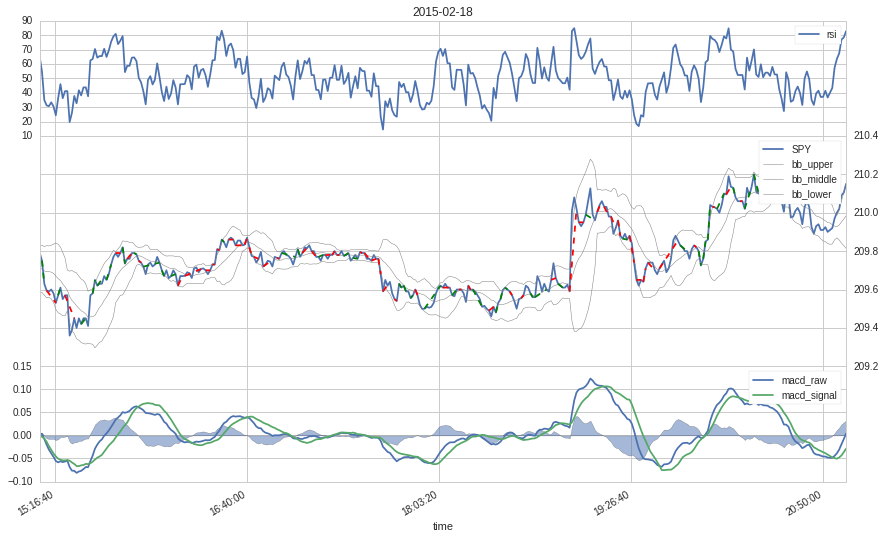

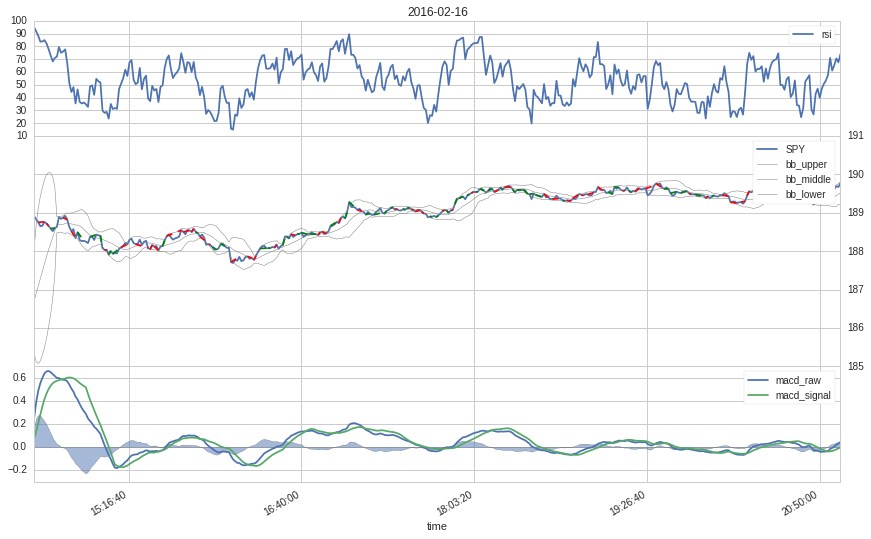

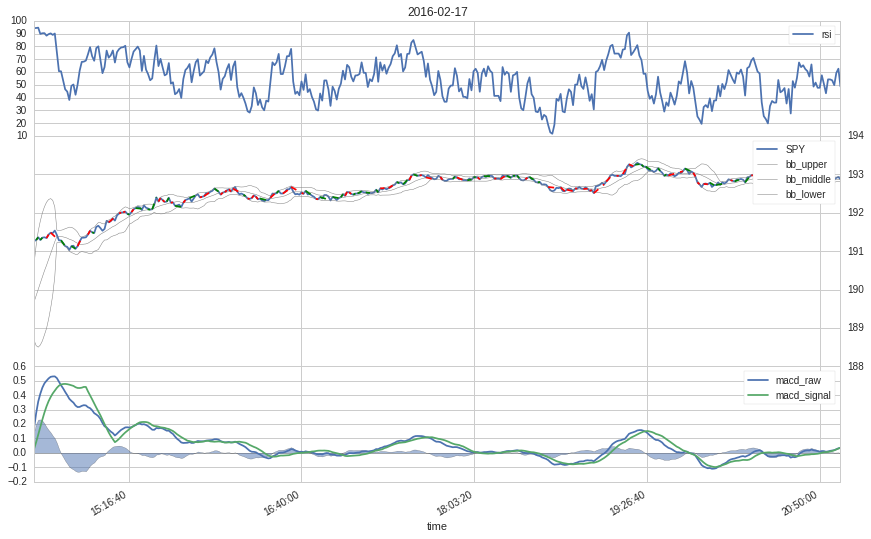

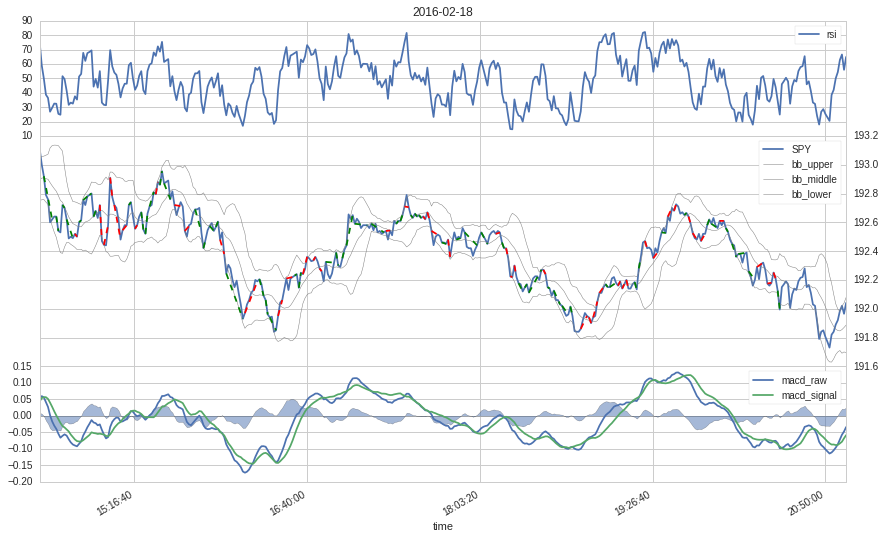

In [153]:
monkey_trading_algorithm = TradingAlgorithm(
    initialize=initialize_monkey_trader, 
    handle_data=handle_data,
    before_trading_start=before_trading_start
)
monkey_trading_algorithm._analyze = analyze
perf_manual=monkey_trading_algorithm.run(data.transpose(2,1,0))

And now the *QLearningTrader*:

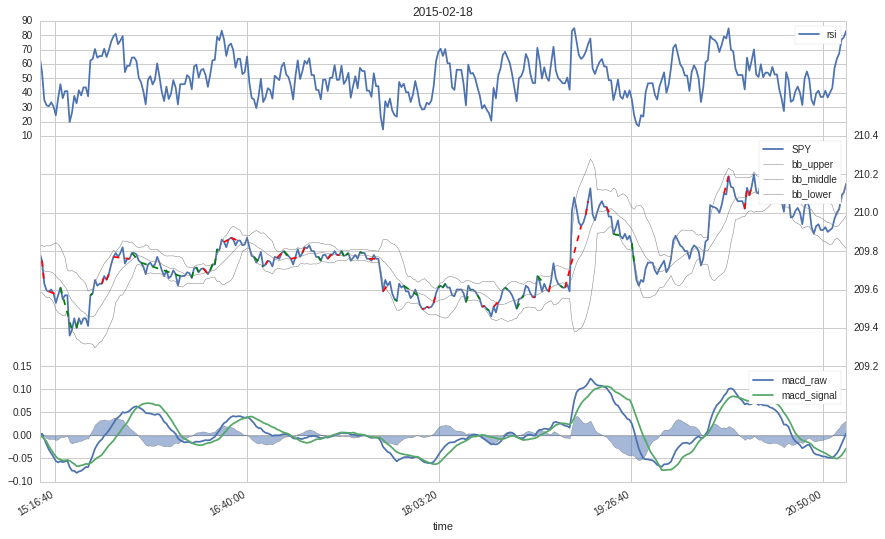

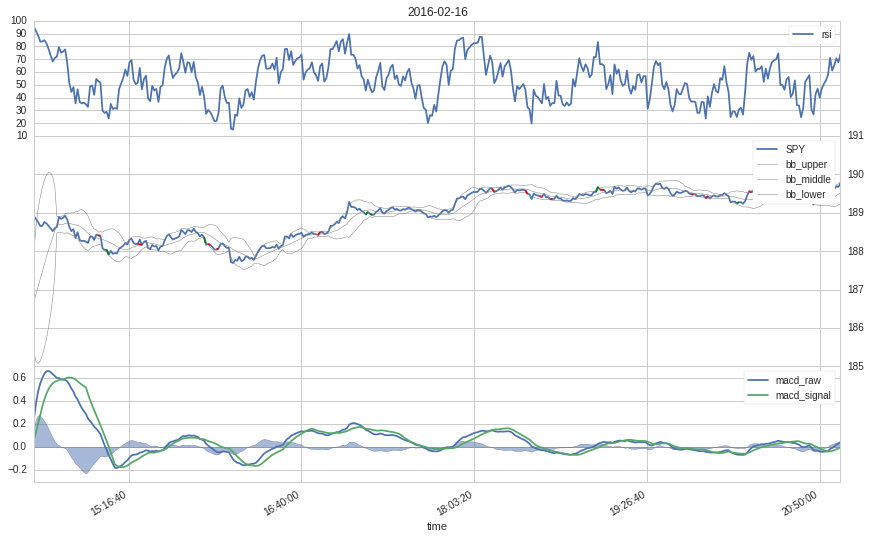

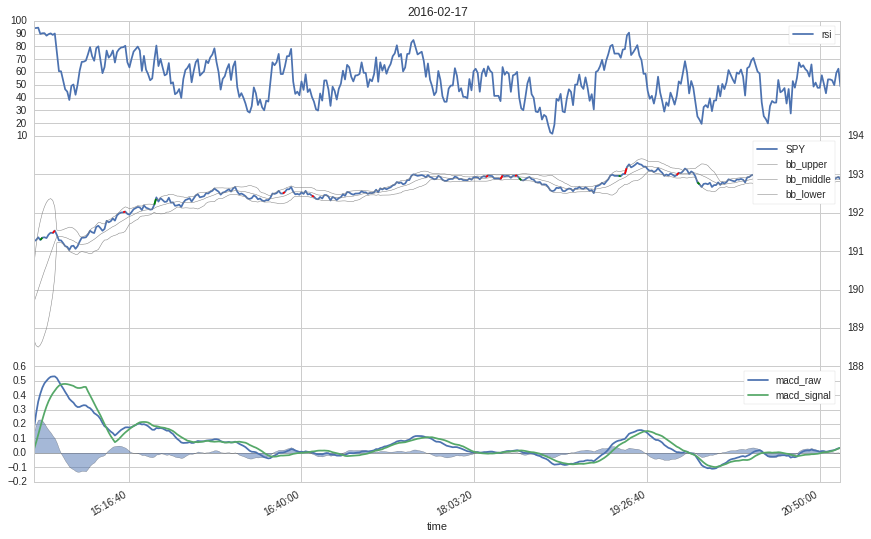

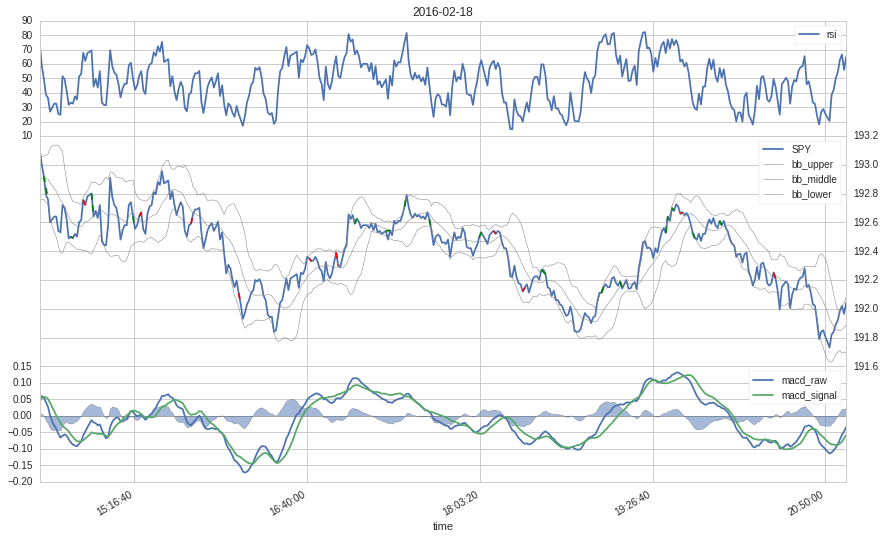

In [150]:
q_learning_trading_algorithm = TradingAlgorithm(
    initialize=initialize_q_learning_trader, 
    handle_data=handle_data,
    before_trading_start=before_trading_start
)
q_learning_trading_algorithm._analyze = analyze
perf_manual = q_learning_trading_algorithm.run(data.transpose(2,1,0))

The individual trades are represented by dashed lines in the plots above, where red indicates a losing and and green a winning trade. 

Finally, the *total_rewards* of both traders are plottet in a single graph, to compare their performance directly: 

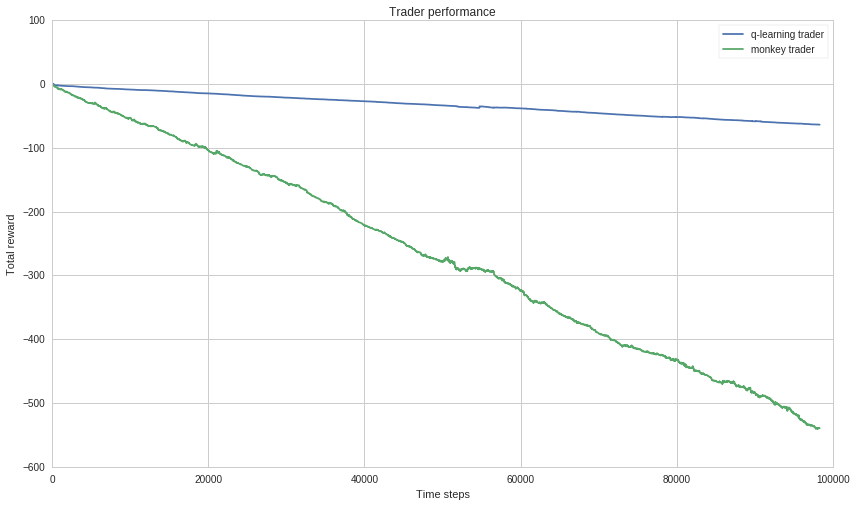

In [154]:
plt.plot(q_learning_trading_algorithm.self_learning_trading_agent.total_reward, label='q-learning trader')
plt.plot(monkey_trading_algorithm.self_learning_trading_agent.total_reward, label='monkey trader')
plt.title('Trader performance')
plt.xlabel('Time steps')
plt.ylabel('Total reward')
plt.legend(loc='upper right')

The direct comparison between the two traders reveals, that the q-learning trader obviously learns something and achieves a significantly higher total reward than the monkey trader benchmark. However, the absolute performance is by no means satisfying. And a review of the 3 final trading days shows, that the q-learning trader favours extremely short trades, contrary to the initial assumption that a higher γ would lead to longer term trades.

### Justification
A day trading setting such as the one used in this project lends itself nicely to a Q-learning implementation: the episodes are naturally defined by the individual days, state and reward can easily be derived from an existing market environment and the actions are limited to a small set of trade types. Due to the large number of possible combinations of the individual elements and the lack of easily reproducible benchmarks however, it is hard to justify and compare the results. The *QLearningTrader* implemented in this project, represents one possible approach to applying *QLearning* to day trading and compared to the constructed benchmark, the results really are significantly better. Although the absolute results may not justify the use of the *QLearningTrader* as day trading system, the implementation at the very least provides ample opportunity for further experimentation and research.

## V. Conclusion

### Free-Form Visualization
The *Q-table* at the core of any Q-Learning algorithm maps states and actions to a real number, which represents the value (or expected reward) for taking action *a* in state *s*. In the case of the *QLearningTrader*, *Q(s,a)* thus returns a value measuring the expected win or loss for taking trading action *a* in market state *s*. Upon completion of the learning algorithm, the *Q-table* contains the learned policy of the *QLearningTrader*, since in every state it takes the trading action with the max value for that particular state, i.e. *argmax[a]Q(s,a)*. A more detailed inspection of the *q-table* is therefore a good approach to gain a deeper insight into what the *QLearningTrader* has actually learned.

For a general graphic overview, the *Q-table* is 

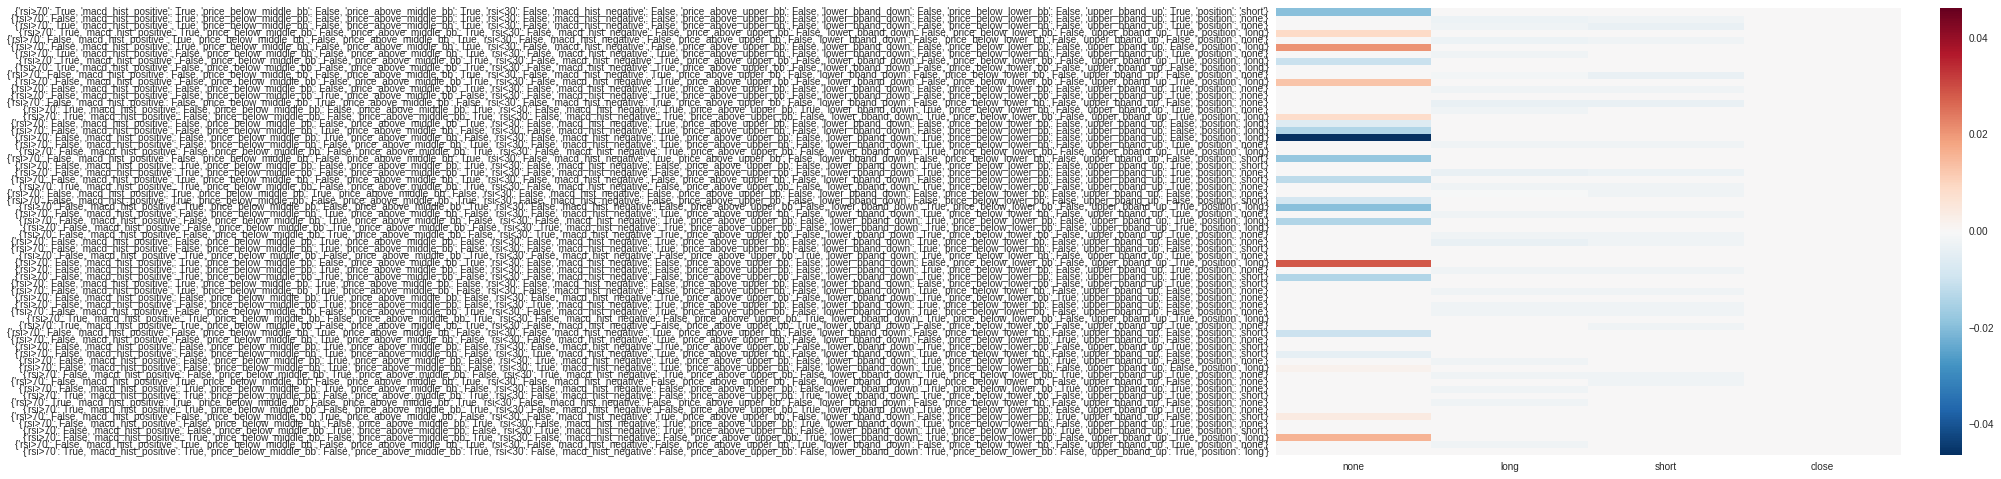

In [59]:
import seaborn as sns
sns.heatmap(q_learning_trading_algorithm.self_learning_trading_agent.q_table.fillna(0))

The heatmap above reveals several interesting points. The most notable finding is that the values for the *close* action zero in any state. This points to a major flaw in the reward system of the *QLearningTrader*: At every update step the reward is calculated based on the positions resulting from the previous update step, the reward for close will always be zero.

Another interesting point is, that only the *none* actions have positive values, while the values of the two trading actions are *<=0* in all states. That means, the *QLearningTrader* was not able to find a highly provitable trading action in any state. This finding is related to the more general one, that the *q-values* are altogether very low, which indicates that the *QLearningTrader* wasn't able to find any strong signal at all. 

A finding that actually confirms some initial design decisions is the relatively small and therefore tractable state space. This could be achieved by deriving a set of discrete states from indicator signals and by limiting the set of trading actions.

### Reflection
The task of developing a reinforcement learning trading agent posed several interesting challenges. 

The first difficulty was to find related work, that could be used for benchmarking and/or orientation. Several papers exist applying different approaches of reinforcement learning to the trading and investment domain. However, the solutions and algorithms introduced by these papers vary widely and are often rather involved and difficult to reproduce. The design and implementation for this project was therefore largely developed from scratch, using some code snippets from a previous project. 

Another difficult task was to find a good market environment with sufficient and reliable market data and with a simulation and backtesting infrastructure to run the Q-learning algorithm over a large number of episodes. Although the *Quantopian* research environment proved to be a very good choice in this regard, several aspects had to be adapted and extended, such as the plotting functionality to illustrate and analyze the trades.  

Given theses challenges and considering the fact that the use of reinforcement learning in investment and trading is still a relatively new research area, the results of the simplified approach introduced in this project are quite respectable. Not only could it be shown that the *QLearningTrader* really is able to learn something useful. The implementation also provides a good playground for further experimentation for any interested member of the growing *Quantopian* community. 

### Improvement
There are several potential optimization targets in the *QLearningTrader* algorithm and the market environment. 

The most obvious candidate for a redesign is the reward system, which assigns zero values to the *close* action, regardless of the wins or losses realised by closing a particular position. In combination with the often negative values for the alternative actions, this may be one of the reasons for the *QLearningAgent*'s strong preference of short and noise-prone trades, despite the high *gamma*. A more general characteristic of the *Q-table* is the consistently low signal level, although it is less clear in what way this affects the overall performance of the agent. The system level could be increased by using a different reward function, such as *(current_price-entry_price)position_size*. A good approach for the close-reward problem could be the assignment of the previous position value to any close action.

Another promising optimization target could be the state space. The possible set of signal combinations derived from three indicators alone is already quite large and it gets much larger when additional indicators are used. A good approach to tackle the problem of state selection could be to identify a set of relatively strong indicator signals and then iterate over the power set to select the combination with the best results. 

Finally, the set of free parameters of the model, specifically *alpha*,*gamma*,*beta* coud be optimzied by a grid search algorithm. This would however mostly help in finetuning the algorithm performance and should therefore be untertaken after the steps described above.